iteration: 14 obstacle nearby!!
[75.05382386916237, 36.87005768508881, 3.141592653589793]
-0.6093414805090843 7.462280936931594e-17 0.7446436393629067
-0.2031870837216981 -0.1872655563858813 0.19866112032098845
-0.2525979061857006 -0.348276495127739 0.07021364510377216
-0.3669615730619521 -0.5888684213760811 0.017327428398929243
-0.4835114738013994 -0.8067098136295694 -0.0005415495026760003
-0.5976599751201562 -0.9959361891811005 -0.007006162574293137
-0.7115252060967044 -1.1670694506559216 -0.010355683436094512
-0.8260592404571376 -1.3238895305109937 -0.01289343439167702
-0.9413195902843156 -1.466176424811 -0.015226521760565895
-1.0568735285706305 -1.5923000311554094 -0.017512229859427228
-1.1719413758770034 -1.7002725539586374 -0.019786215754594758
-1.2854356707653083 -1.7881569335685326 -0.0220490053026645
-1.3959757449536192 -1.854259914003106 -0.024289347949810497
-1.5019081854540948 -1.8972575135813183 -0.026490676279000674
-1.6013454236361475 -1.916297402718938 -0.02863292828716

KeyboardInterrupt: 

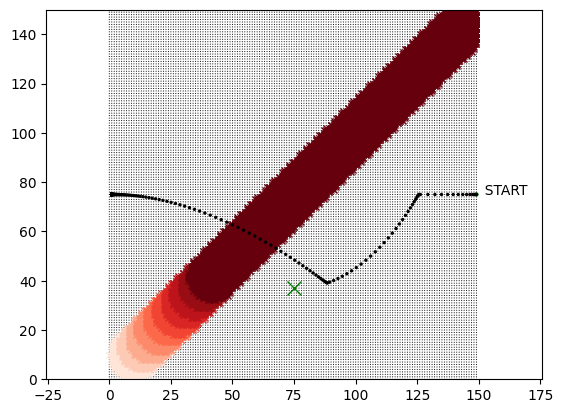

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def drawCoodinate(size, ax):
    x = np.linspace(0,size-1,size)
    y = np.linspace(0,size-1,size)
    u = np.zeros((size,size))
    v = np.zeros((size,size))
    plt.axis('equal')
    ax.quiver(x, y, u, v, scale=1, units='xy')

# Creates axes of plot referenced 'ax'
ax = plt.axes()
size = 150
drawCoodinate(size, ax)
plt.xlim(0, size)
plt.ylim(0, size)

iteration = 0

x_range = 50
y_range = 50

initial_position = [10., 10., np.pi/4]
current_position = initial_position
obstacle_old_position = [0., 0.]
dodge_slope = -(current_position[2])**(-1)
obstacle_velocity = 5.
obstacle_radius = 10.    # (R)
obstacle_x_velo = obstacle_velocity* np.cos(current_position[2])
obstacle_y_velo = obstacle_velocity* np.sin(current_position[2])

robot_radius = 17.    # cm (r)
initial_robot_position = [149., 75., np.pi]    # [x, y, theta]
current_robot_position = initial_robot_position
robot_velocity = 10.
robot_omega = 0.
original_robot_velo = robot_velocity
original_robot_omega = robot_omega
robot_x_velo = robot_velocity* np.cos(current_robot_position[2])
robot_y_velo = robot_velocity* np.sin(current_robot_position[2])

temp_target = [0., 0., 0.]
target = [1., 75., np.pi]
diff_arr = [0., 0., 0.]
controller_index = 0

sampling_freq = 1.    # Hz
safety_margin = 3*robot_radius

turn = 0

def crossing(x, y, iteration, colorcode, zorder_index):
    if colorcode == 1:
        plt.plot(x, y, marker='x', markersize=5, color=plt.cm.Reds((iteration+1)/10), zorder=zorder_index)
    elif colorcode == 2:
        plt.plot(x, y, marker='x', markersize=5, color=plt.cm.Greens((iteration+1)/10), zorder=zorder_index)
    elif colorcode == 3:
        plt.plot(x, y, marker='x', markersize=5, color=plt.cm.Blues((iteration+1)/10), zorder=zorder_index)

def brachistochrone_drawer():
    pass

def controller(diff_x, diff_y, diff_theta, controller_index):
    global robot_velocity, robot_omega, current_robot_position, robot_x_velo, robot_y_velo
    k1 = (1000e-4)      # speed
    k2 = (5*k1)      # trajectory

    z1 = diff_theta
    z2 = diff_x*np.cos(diff_theta) + diff_y*np.sin(diff_theta)
    z3 = diff_x*np.sin(diff_theta) - diff_y*np.cos(diff_theta)
    
    x1 = z1
    x2 = z2
    x3 = -2*z3+z1*z2

    denominator = x1**2+x2**2
    u1 = -k1*x1 + ((k2*x3)/denominator)*x2
    u2 = -k1*x2 - ((k2*x3)/denominator)*x1
    
    robot_omega = u1
    # robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
    # get start from zero velocity
    if controller_index <= 50:
        robot_velocity = ((controller_index+1)/(50+5))*(u2 + z3*u1)
    else:
        robot_velocity = 1*(u2 + z3*u1)   # the linear velocoty of the robot
    robot_x_velo = -robot_velocity* np.cos(current_robot_position[2])      # the negative sign should be modified
    robot_y_velo = -robot_velocity* np.sin(current_robot_position[2])      # the negative sign should be modified


# plotting obstacle's trajectory
while (0<current_position[0] and current_position[0]<size and 0<current_position[1] and current_position[1]<size 
       or 0<current_robot_position[0] and current_robot_position[0]<size and 0<current_robot_position[1] and current_robot_position[1]<size):
    # plot the starting point
    if iteration == 0:
        plt.quiver(current_robot_position[0], current_robot_position[1], 
                   np.cos(current_robot_position[2]), np.sin(current_robot_position[2]),
                     scale=1, units='xy')
        plt.plot(current_robot_position[0], current_robot_position[1], marker="o", markersize=2, markeredgecolor="green", markerfacecolor="green")
        plt.text(current_robot_position[0], current_robot_position[1], '  START', zorder = 3)

    # check if robot near the obstacle
    if np.sqrt((current_position[0]-current_robot_position[0])**2+
               (current_position[1]-current_robot_position[1])**2
               ) <= obstacle_radius+robot_radius+safety_margin and turn == 0:
        print("iteration:", iteration+1, "obstacle nearby!!")
        # get the trajectory of obstacle through robot
        # the formula of the trajectory: y=ax+b
        a = np.tan(current_position[2])
        b = current_position[1] - np.tan(current_position[2])*current_position[0]
        # print("Obstacle trajectory formula: y =", a, "x +", b)
        # dodge_slope = -(1./(np.tan(current_position[2])))  # the slope of the line normal to the trajectory

        # determine the temporary distination robot should go
        if current_position[0] < current_robot_position[0]:  # if the obstacle left to robot, ### Robot go RIGHT ###
            temp_target[0] = current_position[0] + (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_position[2])
            temp_target[1] = current_position[1] - (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_position[2])
        else:                                                # if the obstacle left to robot, ### Robot go LEFT ###
            temp_target[0] = current_position[0] - (obstacle_radius+robot_radius)*np.cos(np.pi/2-current_position[2])
            temp_target[1] = current_position[1] + (obstacle_radius+robot_radius)*np.sin(np.pi/2-current_position[2])
        temp_target[2] = current_robot_position[2]
        plt.plot(temp_target[0], temp_target[1], marker='x', markersize=10, color = 'g')
        print(temp_target)
        controller_index = 0
        turn = 1      
    else:
        # controller to distination
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - target[j]
        controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index)  
        controller_index += 1  

    # calculate the difference
    if turn == 1:
        for j in range(3):
            diff_arr[j] = current_robot_position[j] - temp_target[j]
        controller(diff_arr[0], diff_arr[1], diff_arr[2], controller_index) 
        controller_index += 1  
        print(robot_x_velo, robot_y_velo, robot_omega)   # print for debugging
        if np.sqrt((current_robot_position[0]-temp_target[0])**2 + 
                   (current_robot_position[1]-temp_target[1])**2) < robot_radius:  # if robot is close enough to temp. distination, continue
            turn = 0
            controller_index = 0

    # plot the current status (arrow)
    plt.quiver(current_robot_position[0], current_robot_position[1],
                1*np.cos(current_robot_position[2]), 1*np.sin(current_robot_position[2]),
                scale=1, units='xy', zorder = 3)

    for x in range(size):
        for y in range(size):
            if np.sqrt((current_position[0]-x)**2 + (current_position[1]-y)**2) <= obstacle_radius:
                crossing(x, y, iteration, 1, 1)
                # print out the position cannot go through
                # print("time:", iteration/sampling_freq, "(", x, ",", y, ")")
            # if np.sqrt((current_robot_position[0]-x)**2 + (current_robot_position[1]-y)**2) <= robot_radius:
            #     crossing(x, y, iteration, 2, 2)
                # print out the position cannot go through
                # print("time:", iteration/sampling_freq, "(", x, ",", y, ")")
    iteration += 1

    # moving to next position
    current_position[0] += obstacle_x_velo*(1/sampling_freq)
    current_position[1] += obstacle_y_velo*(1/sampling_freq)
    current_robot_position[0] += robot_x_velo*(1/sampling_freq)
    current_robot_position[1] += robot_y_velo*(1/sampling_freq)
    current_robot_position[2] += robot_omega*(1/sampling_freq)
